# HW1

By:
1. Roni Roitbord (313575599)
2. Lior Yaacov Ben Ezra (__YOUR ID__)



### 1. Quantization

In [24]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

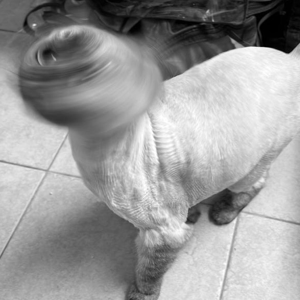

In [20]:
og_image = Image.open("./Drillocato.jpg")
gray_image = ImageOps.grayscale(og_image)
gray_image = gray_image.resize((300,300))
display(gray_image)

### 1:
We would like to estimate the probability density function (pdf) of the gray levels
in the image using the image histogram. If the histogram seems too uniform, please
pick another image with a non-uniform distribution.

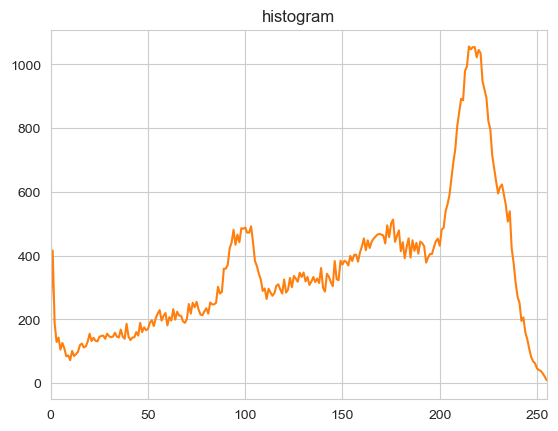

In [23]:
def calc_greyscale_hist(image):
    plt.plot(1,2)
    hist,bin = np.histogram(image,256,[0,255])
    plt.xlim([0,255])
    plt.plot(hist)
    plt.title('histogram')
    plt.show()

calc_greyscale_hist(gray_image)

We can see that the histogram does not represents a uniform distribution.

### 2:
 Apply uniform quantization on the image using b bits per pixel.
    a. Show the MSE as a function of the bit-budget b for b = 1, ..., 8.
    b. Plot the decision and representation levels for representative b values.